## Data Download and extract
- mount drive
- extract zip file

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!rm -rf '/content/Skin cancer ISIC The International Skin Imaging Collaboration'
!unzip '/content/gdrive/MyDrive/upGrad/CNN_assignment.zip' >> zip_log.txt # change zip file path accordingly
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 34.7 MB/s 


### Importing all the important libraries

In [3]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import random
import cv2
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import albumentations as A

In [4]:
import keras.layers as L
from keras.models import Model, Sequential
from keras import losses
import tensorflow as tf
import tensorflow_addons as tfa

In [5]:
pd.options.plotting.backend = "plotly"

## Visualize the data 
- Visualize distribution of data in each class
- Visualize 5 image of each class
- Visualize bartch of image generated by TF

In [6]:
data_base_path = './Skin cancer ISIC The International Skin Imaging Collaboration'
test_path, train_path = (
    os.path.join(data_base_path ,'Test'),
    os.path.join(data_base_path ,'Train')
)
classes = list(map(
    lambda x: x.split('/')[-1], 
    glob.glob(os.path.join(train_path, '*'))
))
num_image = list(map(
    lambda x: len(glob.glob(os.path.join(train_path, x, '*.jpg'))),
    classes
))

In [7]:
fig = px.bar(
    x=classes,
    y=num_image
)
fig.show()

In [84]:
num_image = list(map(
    lambda x: len(glob.glob(os.path.join(test_path, x, '*.jpg'))),
    classes
))
fig = px.bar(
    x=classes,
    y=num_image
)
fig.show()

In [8]:
def plot_images(
    subset = '*', 
    img_per_class = 5,
    classes = classes,
    base_path = train_path,
    figsize = (10, 10),
    image_size = (180, 180)
):
  if subset == '*':
    subset = classes
  else:
    assert type(subset) == list, "'subset' must be a list"
    subset = list(set(classes).intersection(set(subset)))
  assert len(subset) > 0, "'subset' values must belong to 'classes'"

  fig = plt.figure(figsize=figsize)
  
  rows = len(classes)
  columns = img_per_class
  count = 1

  for _cls in classes:
    if _cls != 'output':
      img_paths = random.sample(
          glob.glob(os.path.join(base_path, _cls, '*.jpg')),
          img_per_class
      )
      for img_path in img_paths:
        img = cv2.imread(img_path)
        fig.add_subplot(rows, columns, count)
    
        # showing image
        plt.imshow(cv2.resize(img, image_size))
        # plt.axis('off')
        if(count % columns == 1):
          plt.ylabel(f'{_cls[:5]}...')
        count+=1

In [9]:
def tf_view_image(ds, batch_size):
    image, label = next(ds.as_numpy_iterator())
    label_count = np.unique(np.argmax(label, axis=-1), return_counts=True)
    image = image / 255
    
    fig = plt.figure(figsize=(15, 15))
    for i in range(batch_size):
        ax = fig.add_subplot(8, int(batch_size/8), i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {classes[np.argmax(label[i])][:3]}...")

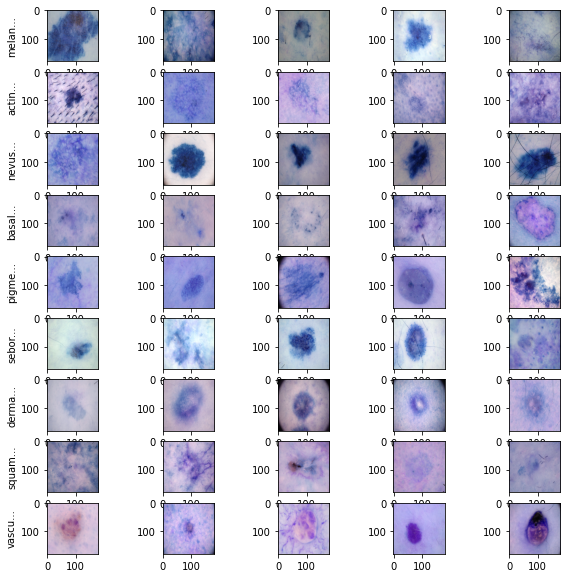

In [10]:
plot_images()

In [11]:
batch_size = 32
image_size = (180, 180)
validation_split = 0.2
random_state = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=5
max_val = image_size[0] * image_size[1] * 3
epochs = 20
seed = 123

In [12]:
def plot_hist(history, epochs):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

## Dataset Pipeline

In [13]:
tf_train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    image_size=(180, 180),
    batch_size=batch_size,
    label_mode = 'categorical',
    subset='training',
    smart_resize=False,
    seed=seed
)

tf_train_dataset = tf_train_dataset.cache()
tf_train_dataset = tf_train_dataset.shuffle(1000, seed=seed)
tf_train_dataset = tf_train_dataset.prefetch(
    buffer_size=buffer_size
)

tf_test_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    image_size=(180, 180),
    batch_size=batch_size,
    label_mode = 'categorical',
    subset='validation',
    smart_resize=False,
    seed = seed
)
tf_test_dataset = tf_test_dataset.cache()
tf_test_dataset = tf_test_dataset.prefetch(
    buffer_size=buffer_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


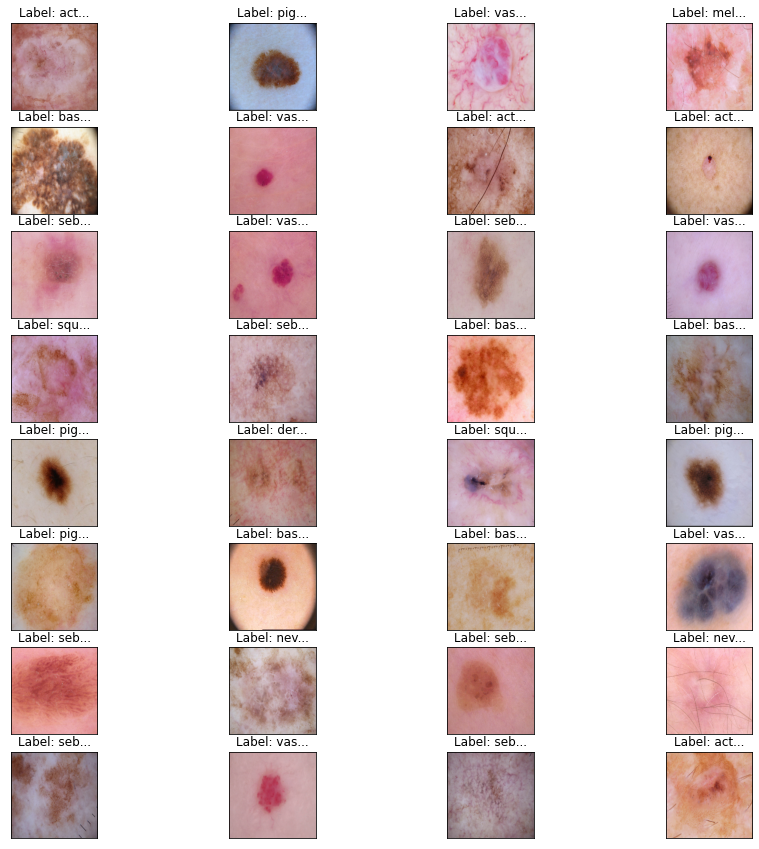

In [14]:
tf_view_image(tf_train_dataset, batch_size)

# Model

### Created Custom layer (ConveLayers and DenseLayers)
- ConveLayers genrated all conv layers as per config and same for DenseLayers
also.
- This will help to get rid out of rewriting code for diffent configurations

In [15]:
class ConvLayers(L.Layer):
  def __init__(
    self, 
    filters = [], 
    kernel_size = [],
    padding = [],
    batch_norm = [], 
    max_pool = [],
    dropout = [], 
  ):
    super(ConvLayers, self).__init__()
    assert len(filters) > 0 or len(batch_norm) > 0 or\
    len(kernel_size) > 0 or len(max_pool) > 0 or len(dropout) > 0 or\
    len(padding) > 0, 'lenght or each param is 0'

    assert len(filters) == len(batch_norm) == len(max_pool) == len(dropout),\
    'missing param for conv layers'

    self._layers = []
    self._filters = filters
    self._kernel_size = kernel_size
    self._padding = padding
    self._batch_norm = batch_norm
    self._max_pool = max_pool
    self._dropout = dropout
  
  def build(self, input_shape=None):
    for i, filter in enumerate(self._filters):
      layer = L.Conv2D(
          filter, 
          kernel_size=self._kernel_size[i], 
          padding=self._padding[i], 
          activation='relu'
        )
      self._layers.append({"always": True, "layer": layer})
      if(self._batch_norm[i]):
        layer = L.BatchNormalization()
        self._layers.append({"always": True, "layer": layer})
      if self._max_pool[i]:
        layer = L.MaxPool2D()
        self._layers.append({"always": True, "layer": layer})
      if(self._dropout[i]):
        layer = L.Dropout(self._dropout[i])
        self._layers.append({"always": False, "layer": layer})
    super().build(input_shape)
  
  def call(self, inputs, training=False):
    x = inputs
    for _layer in self._layers:
      if _layer["always"] or training:
        x = _layer["layer"](x)
    return x
  
  def get_config(self):
    config = super().get_config()
    config.update({
      "filters": self._filters, 
      "kernel_size": self._kernel_size,
      "padding": self._padding,
      "batch_norm": self._batch_norm, 
      "max_pool": self._max_pool,
      "dropout": self._dropout,
    })
    return config


In [16]:
class DenseLayers(L.Layer):
  def __init__(
    self,
    dense = [],
    batch_norm = [], 
    dropout = [],
    n_class = 0
  ):
    super(DenseLayers, self).__init__()
    assert len(dense) > 0 or len(batch_norm) > 0 or\
    len(dropout) > 0, 'lenght or each param is 0'

    assert len(dense) == len(batch_norm) == len(dropout),\
    'missing param for dense layers'
    
    assert n_class > 0, 'number of class if 0'

    self._layers = []
    self._dense = dense
    self._batch_norm = batch_norm
    self._dropout = dropout
    self._n_class = n_class
  
  def build(self, input_shape=None):
    for i, dense in enumerate(self._dense):
      layer = L.Dense(dense, activation='relu')
      self._layers.append({"always": True, "layer": layer})
      if(self._batch_norm[i]):
        layer = L.BatchNormalization()
        self._layers.append({"always": True, "layer": layer})
      if(self._dropout[i]):
        layer = L.Dropout(self._dropout[i])
        self._layers.append({"always": False, "layer": layer})
    layer = L.Dense(self._n_class, activation='softmax')
    self._layers.append({"always": True, "layer": layer})
    super().build(input_shape)
  
  def call(self, inputs, training=False):
    x = inputs
    for _layer in self._layers:
      if _layer["always"] or training:
        x = _layer["layer"](x)
    return x

  def get_config(self):
    config = super().get_config()
    config.update({
        "dense": self._dense,
        "batch_norm": self._batch_norm, 
        "dropout": self._dropout,
        "n_class": self._n_class
    })
    return config


In [17]:
DataAugmentation = Sequential([
  L.RandomFlip("horizontal_and_vertical"),
  L.RandomRotation(0.3)
])

### Model V1
This is a sequential model with 32, 64 filter wil 3,3 kernel size and for dense used 128 units.

In [18]:
input = L.Input(shape=(*image_size, 3))
aug = DataAugmentation(input)
rescale = L.Rescaling(scale=1./255.)(aug)
conv_block = ConvLayers(
  filters = [32, 64],
  kernel_size = [(3,3), (3, 3)],
  padding = ['same', 'same'],
  batch_norm = [False, False],
  max_pool = [True, True],
  dropout = [0.1, 0.1]
)(rescale)
flatten = L.Flatten()(conv_block)
dense_block = DenseLayers(
  dense = [128],
  batch_norm = [False], 
  dropout = [0.25],
  n_class = 9
)(flatten)

model = Model(inputs = input, outputs = dense_block)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv_layers (ConvLayers)    (None, 45, 45, 64)        19392     
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dense_layers (DenseLayers)  (None, 9)                 16590089  
                                                                 
Total params: 16,609,481
Trainable params: 16,609,481
Non-tra

In [20]:
def compile_model(model, epoch_limit=20):
  def lr_scheduler(epoch, lr):
    if epoch < epoch_limit:
      return lr
    else:
      return lr * tf.math.exp(-0.1)
  opt = tf.keras.optimizers.Adam()
  loss = tf.keras.losses.CategoricalCrossentropy()
  model.compile(loss = loss, optimizer=opt, metrics=['acc'])
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir='./logs', 
      histogram_freq=0, 
      write_graph=True, 
      write_images=True
  )
  decay_lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
  return [
    tensorboard_callback,
    decay_lr_callback
  ]

callbacks = compile_model(model)

In [21]:
!rm -rf logs
!rm -rf model.trans

In [22]:
hist = model.fit(
    tf_train_dataset,
    validation_data = tf_test_dataset,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/20
56/56 [==============================] - 18s 70ms/step - loss: 3.5058 - acc: 0.2333 - val_loss: 2.0155 - val_acc: 0.2953 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.8767 - acc: 0.3304 - val_loss: 2.0266 - val_acc: 0.2438 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.8702 - acc: 0.3147 - val_loss: 1.7900 - val_acc: 0.4452 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6977 - acc: 0.4023 - val_loss: 1.7989 - val_acc: 0.3602 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5648 - acc: 0.4537 - val_loss: 1.5336 - val_acc: 0.4944 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5468 - acc: 0.4688 - val_loss: 1.6904 - val_acc: 0.4072 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5342 - acc: 0.4654 - val_loss: 1.4504 - val_acc: 0.5257 - lr

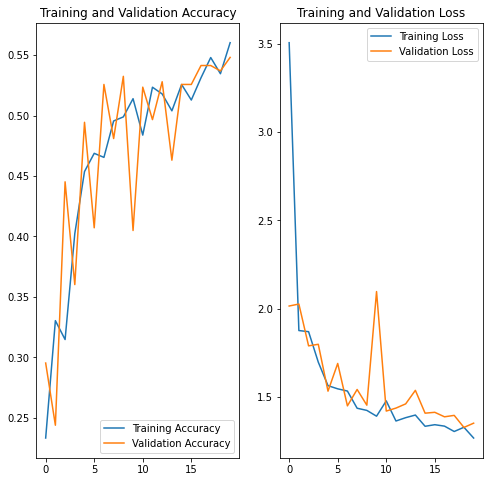

In [23]:
plot_hist(hist, epochs)

## Model V1 Analysis
- Model seems not overfitted but not able to achive a ccuracy upto some extent
so we can say that model is underfitted 
- Created a model with 32, 64 filter oc conv with kernel size 3 and then passed to dense to classes. In this experiment achived approx 55% accuracy on train and valiation set but when tested on test set then only  35% accuracy which seems that model is under fited.

In [24]:
tf_test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(180, 180),
    batch_size=batch_size,
    label_mode = 'categorical'
)
tf_test_dataset = tf_test_dataset.prefetch(
    buffer_size=buffer_size
)

Found 118 files belonging to 9 classes.


In [25]:
model.evaluate(tf_test_dataset)

4/4 [==============================] - 3s 64ms/step - loss: 2.3696 - acc: 0.3559


[2.369602680206299, 0.35593220591545105]

# Agumentation

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from Augmentor import Pipeline

In [32]:
!rm -rf ./Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/output
!rm -rf ./Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/*/output

## Augmentor
- Agument the image by rotating, fliP nd zoom
- Creating 500 sample image for each class

In [33]:
pipeline = Pipeline()
pipeline.rotate(probability=0.6, max_left_rotation=10, max_right_rotation=10)
pipeline.flip_random(probability=0.4)
pipeline.zoom(probability=0.4, min_factor=1.1, max_factor=1.2)

In [34]:
pipeline.status()

Operations: 3
	0: RotateRange (probability=0.6 max_left_rotation=-10 max_right_rotation=10 )
	1: Flip (probability=0.4 top_bottom_left_right=RANDOM )
	2: Zoom (probability=0.4 min_factor=1.1 max_factor=1.2 )
Images: 0

You can remove operations using the appropriate index and the remove_operation(index) function.


In [35]:
for x in classes:
  pipeline.add_further_directory(
      os.path.join(train_path, x)
  )
  pipeline.sample(500)

Initialised with 438 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F32FDFE8DD0>: 100%|██████████| 500/500 [00:43<00:00, 11.58 Samples/s]


Initialised with 114 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32FE5BF750>: 100%|██████████| 500/500 [00:08<00:00, 60.60 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F32FE199310>: 100%|██████████| 500/500 [00:43<00:00, 11.51 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32FDFA3FD0>: 100%|██████████| 500/500 [00:08<00:00, 60.68 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F32FDFC1A90>: 100%|██████████| 500/500 [00:08<00:00, 59.81 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F32FE73D250>: 100%|██████████| 500/500 [00:19<00:00, 25.75 Samples/s]


Initialised with 95 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32FE758850>: 100%|██████████| 500/500 [00:08<00:00, 58.96 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32FE0D5A50>: 100%|██████████| 500/500 [00:08<00:00, 60.43 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32FE5BFC50>: 100%|██████████| 500/500 [00:08<00:00, 58.95 Samples/s] 


## Visualise after agumentation 
- Every class have 500 images

In [38]:
data_base_path = './Skin cancer ISIC The International Skin Imaging Collaboration'
test_path, train_path = (
    os.path.join(data_base_path ,'Test'),
    os.path.join(data_base_path ,'Train',)
)
classes = list(map(
    lambda x: x.split('/')[-1], 
    glob.glob(os.path.join(train_path, '*'))
))
num_image = list(map(
    lambda x: len(glob.glob(os.path.join(train_path,  x, 'output', '*.jpg'))),
    classes
))

In [39]:
fig = px.bar(
    x=classes,
    y=num_image
)
fig.show()

In [40]:
path_list = [x for x in glob.glob(os.path.join(train_path, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(train_path, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['path_lable'] = df2['Path'].map(lambda x: x.split('/')[-3])

In [41]:
df2['Label'].value_counts()

melanoma                      500
actinic keratosis             500
nevus                         500
basal cell carcinoma          500
pigmented benign keratosis    500
seborrheic keratosis          500
dermatofibroma                500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [42]:
(df2['Label'] == df2['path_lable']).value_counts() 

True    4500
dtype: int64

## Dataset Pipeline

In [50]:
tf_train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical',
    subset='training',
    smart_resize=False,
    seed = seed
)

tf_test_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical',
    subset='validation',
    smart_resize=False,
    seed = seed
)

tf_train_dataset = tf_train_dataset.shuffle(1000, seed=seed)
tf_train_dataset = tf_train_dataset.prefetch(
    buffer_size=buffer_size
)
tf_test_dataset = tf_test_dataset.prefetch(
    buffer_size=buffer_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


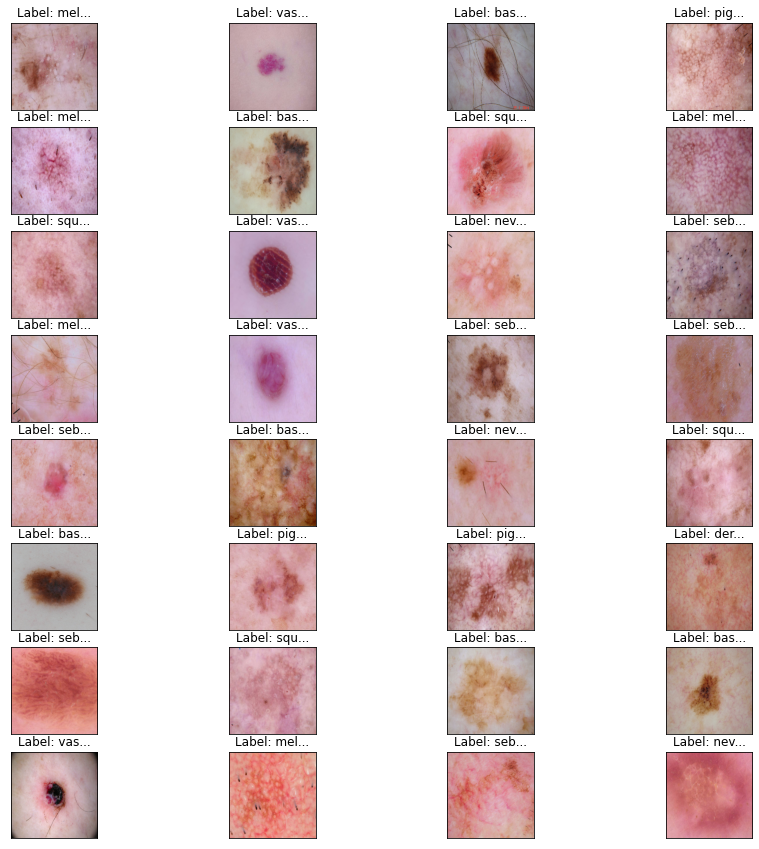

In [51]:
tf_view_image(tf_train_dataset, batch_size)

In [52]:
input = L.Input(shape=(*image_size, 3))
rescale = L.Rescaling(scale=1./255.)(input)
conv_block = ConvLayers(
    filters = [
                32, 32, 
                64, 64, 
                128, 128,
              ],
    kernel_size = [
                    (3, 3), (1, 1), 
                    (3, 3), (1, 1), 
                    (3, 3), (1, 1),
                  ],
    padding = [
                'valid', 'same', 
                'valid','same', 
                'valid', 'same',
              ],
    batch_norm = [
                  False, False, 
                  False, False, 
                  False, False,
                ],
    max_pool = [
                False, True, 
                False, True, 
                False, True,
              ],
    dropout = [
                0, 0.7, 
                0, 0.7, 
                0, 0.7,
              ]
)(rescale)
flatten = L.Flatten()(conv_block)
dense_block = DenseLayers(
    dense = [100],
    batch_norm = [False], 
    dropout = [0.25],
    n_class = 9
)(flatten)

model_v2 = Model(inputs = input, outputs = dense_block)

In [53]:
model_v2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv_layers_2 (ConvLayers)  (None, 20, 20, 128)       114976    
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_layers_2 (DenseLayers  (None, 9)                5121009   
 )                                                               
                                                                 
Total params: 5,235,985
Trainable params: 5,235,985
Non-trainable params: 0
_________________________________________________

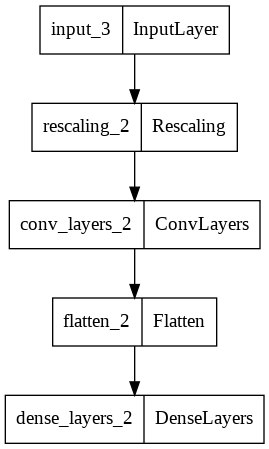

In [54]:
tf.keras.utils.plot_model(model_v2)

In [55]:
callbacks = compile_model(model_v2, 40)

In [56]:
epochs = 50
hist = model_v2.fit(
    tf_train_dataset,
    validation_data = tf_test_dataset,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/50
169/169 [==============================] - 24s 75ms/step - loss: 2.1708 - acc: 0.1499 - val_loss: 2.6778 - val_acc: 0.1425 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 23s 74ms/step - loss: 1.8907 - acc: 0.2582 - val_loss: 1.7828 - val_acc: 0.3044 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 23s 74ms/step - loss: 1.7534 - acc: 0.3220 - val_loss: 1.7602 - val_acc: 0.3408 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 23s 74ms/step - loss: 1.6157 - acc: 0.3789 - val_loss: 1.9788 - val_acc: 0.3125 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 23s 74ms/step - loss: 1.5432 - acc: 0.4086 - val_loss: 1.5282 - val_acc: 0.4046 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 23s 74ms/step - loss: 1.4783 - acc: 0.4308 - val_loss: 1.5165 - val_acc: 0.4202 - lr: 0.0010
Epoch 7/50
169/169 [==============================] - 23s 74ms/step - loss: 1.4554 - acc: 0.4368 - val_loss: 1.6749 - 

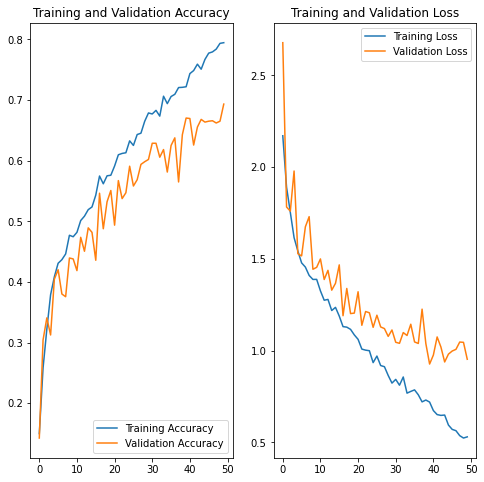

In [57]:
plot_hist(hist, epochs)

## Model V2 analysis
- With agumentation and increasing conv layer and epoch able to achive 79.5% accuracy on train and 69.5 % on test which seem model little bit overfitted

In [58]:
tf_test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(180, 180),
    batch_size=batch_size,
    label_mode = 'categorical'
)
tf_test_dataset = tf_test_dataset.prefetch(
    buffer_size=buffer_size
)

Found 118 files belonging to 9 classes.


In [59]:
model_v2.evaluate(tf_test_dataset)

4/4 [==============================] - 2s 134ms/step - loss: 3.9727 - acc: 0.3475


[3.9727301597595215, 0.347457617521286]